# Import Required packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import os
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [9]:
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Import the dataset

In [12]:
# download the required dataset from the api provided by standford

!wget 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
# extract downloaded files
!tar xvzf aclImdb_v1.tar.gz


Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [13]:
# Function to fetch the dataset
def fetch_reviews(path):
  data = []
  #path = 'aclImdb/train/pos/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())
      
  return data


df_train_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/test/neg/'), 'label': 0})

# Merging all df's for data cleaning and preprocessing step.
df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
print("Total reviews in df: ", df.shape)
df.head()

Total reviews in df:  (50000, 2)


,review,label
0,After finally watching Walt Disney's Song of t...,1
1,"I was all ready to pan this episode, seeing th...",1
2,There is so much that can be said about this f...,1
3,"OK, so the Oscars seem to get hyped just a lit...",1
4,The Sea is Watching was an interesting film ex...,1


Check for the balance of the dataset

In [5]:
print("Total Number of positive reviews in data: ", df[df['label']==1].shape[0])
print("Total Number of negative reviews in data: ", df[df['label']==0].shape[0])

Total Number of positive reviews in data:  25000
Total Number of negative reviews in data:  25000


Data is well balanced with positive reviews 25k and negative reviews 25k

In [6]:
df.head()

,review,label
0,After finally watching Walt Disney's Song of t...,1
1,"I was all ready to pan this episode, seeing th...",1
2,There is so much that can be said about this f...,1
3,"OK, so the Oscars seem to get hyped just a lit...",1
4,The Sea is Watching was an interesting film ex...,1


# Data Processing 

We use NLTK package here

In [14]:
stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):
    
  # data cleaning
  review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words
  
  # lowercase
  review = review.lower()
  
  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens
  
  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words
  
  # lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]
  
  # join words in preprocessed review
  review = ' '.join(review)
  
  return review

In [15]:
df['preprocessed_review'] = df['review'].apply(lambda review: data_preprocessing(review))
df.head()

,review,label,preprocessed_review
0,After finally watching Walt Disney's Song of t...,1,finally watching walt disney song south myspac...
1,"I was all ready to pan this episode, seeing th...",1,ready pan episode seeing master really horror ...
2,There is so much that can be said about this f...,1,much said film not typical nunsploitation cour...
3,"OK, so the Oscars seem to get hyped just a lit...",1,ok oscar seem get hyped little year rooting go...
4,The Sea is Watching was an interesting film ex...,1,sea watching interesting film experience first...


## Preview of Positive reviews

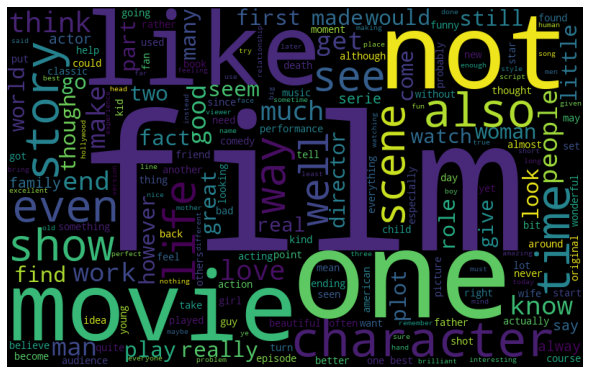

In [18]:
from wordcloud import WordCloud

words_list = df[df['label']==1]['preprocessed_review'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Preview of Negative reviews

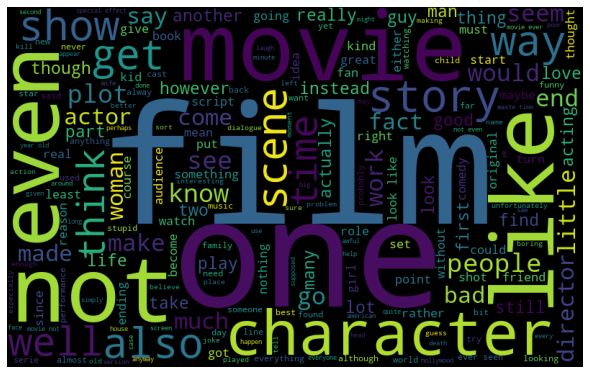

In [19]:
words_list = df[df['label']==0]['preprocessed_review'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Train test split

In [21]:
data = df.copy()
y = data['label'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (35000, 2) (35000,)
Test data: (15000, 2) (15000,)


# TFIDF Vectorization of Dataset

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_review_tfidf = vectorizer.fit_transform(X_train['preprocessed_review'])
X_test_review_tfidf = vectorizer.transform(X_test['preprocessed_review'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)

X_train_review_tfidf shape:  (35000, 19544)
X_test_review_tfidf shape:  (15000, 19544)


# Model

##  Naive Bayes

In [25]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.8598


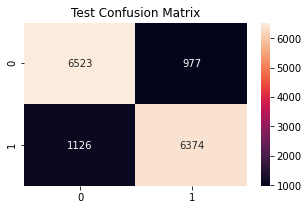

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

## Logisitc Regression 

In [31]:
clf = LogisticRegression()
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.8947333333333334


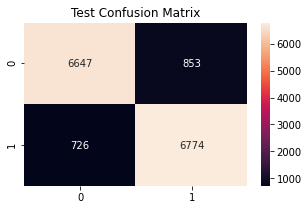

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

## Random Forest Classifier

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.8570666666666666


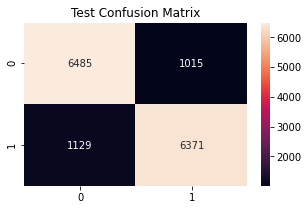

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

# Summary

In [36]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Model', 'Accuracy']
x.add_row(['Naive Bayes', '0.8598%'])
x.add_row(['Logisitc Regression', '0.89473%'])
x.add_row(['Random Forest Classifier', '0.85706%'])
print(x)

+--------------------------+----------+
|          Model           | Accuracy |
+--------------------------+----------+
|       Naive Bayes        | 0.8598%  |
|   Logisitc Regression    | 0.89473% |
| Random Forest Classifier | 0.85706% |
+--------------------------+----------+
